In [1]:
options(warn=-1)
library(igraph)
library(Matrix)
library(pracma)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘pracma’

The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu



## 3. PageRank

#### The PageRank algorithm, as used by the Google search engine, exploits the linkage structure of the web to compute global “importance” scores that can be used to influence the ranking of search results. Here, we use random walk to simulate PageRank.

In [2]:
create_transition_matrix = function (g){
    
    # WARNING: make sure your graph is connected (you might input GCC of your graph)
    
    vs = V(g)
    n = vcount(g)
    adj = as_adjacency_matrix(g)
    adj[diag(rowSums(adj) == 0)] = 1  # handle if the user is using the function for networks with isolated nodes by creating self-edges
    z = matrix(rowSums(adj, , 1))
    transition_matrix = adj / repmat(z, 1, n)  # normalize to get probabilities
    
    return(transition_matrix)
}

In [3]:
random_walk = function (g, num_steps, start_node, transition_matrix = NULL){
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
        
    v = start_node
    for(i in 1:num_steps){
        fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
        PMF = transition_matrix[v, ]
        v = sample(1:vcount(g), 1, prob = PMF)        
    }
    
    return(v)
}

#### 3.(a) Create a directed random network with 1000 nodes, using the preferential attachment model, where m = 4. Note that in this directed model, the out-degree of every node is m, while the in-degrees follow a power law distribution. Measure the probability that the walker visits each node. Is this probability related to the degree of the nodes?

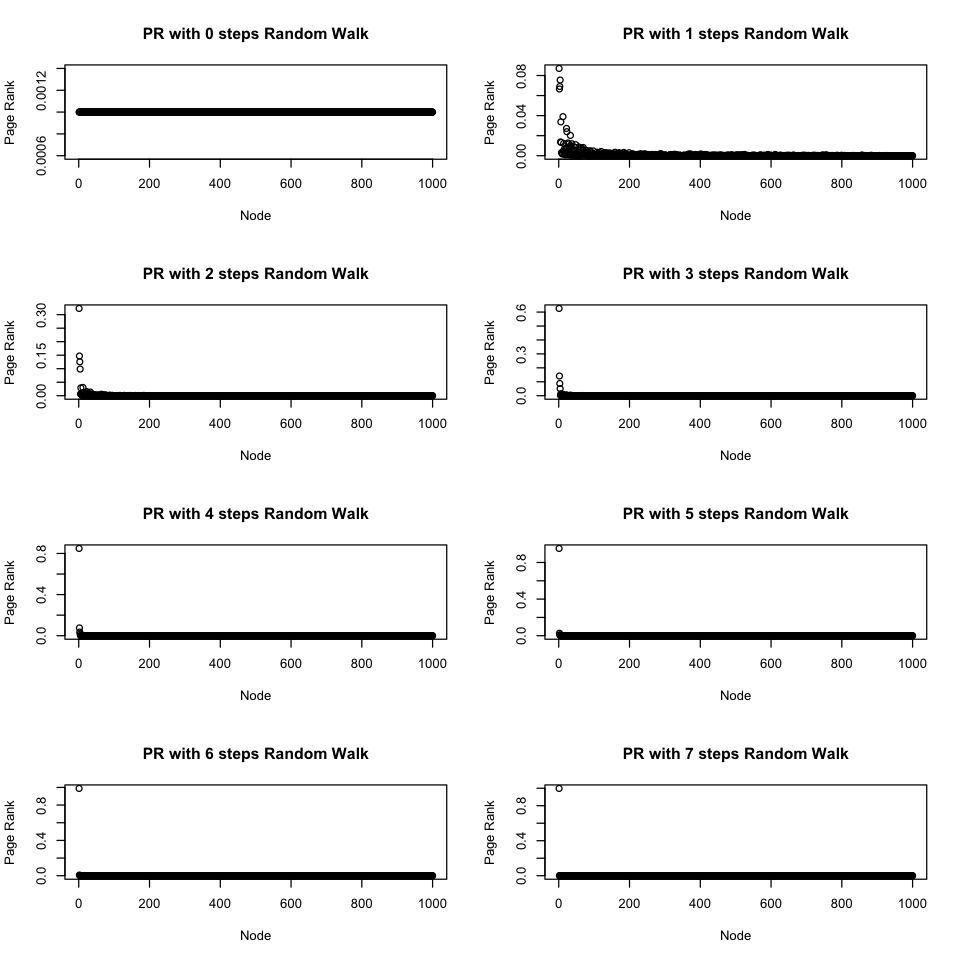

In [4]:
n <- 1000
g <- sample_pa(n, power = 1, m = 4, directed = TRUE)
maxSteps <- 10
g.tMatrix <- create_transition_matrix(g)
jumpMatrix <- array(1, c(n, n, maxSteps))
jumpMatrix[, , 1] <- diag(n)
PR_Density <- array(1, c(n, maxSteps))
TP_state <- array(1/n, n)

for (i in 2:maxSteps){
    jumpMatrix[, , i] = as.matrix(jumpMatrix[, , i - 1] %*% g.tMatrix)
}

for (i in 1:maxSteps){
    PR_Density[, i] <- as.vector(TP_state %*% jumpMatrix [, , i])
}


par(mfrow = c(4, 2))
options(repr.plot.width=8, repr.plot.height= 8)
for (i in 1:8){
    plot(V(g), PR_Density[, i], 
    main=sprintf("PR with %d steps Random Walk", i - 1), xlab="Node", ylab="Page Rank")
}



#### 3.(b) In all previous questions, we didn’t have any teleportation. Now, we use a teleportation probability of alpha = 015. By performing random walks on the network created in 3(a), measure the probability that the walker visits each node. Is this probability related to the degree of the node?

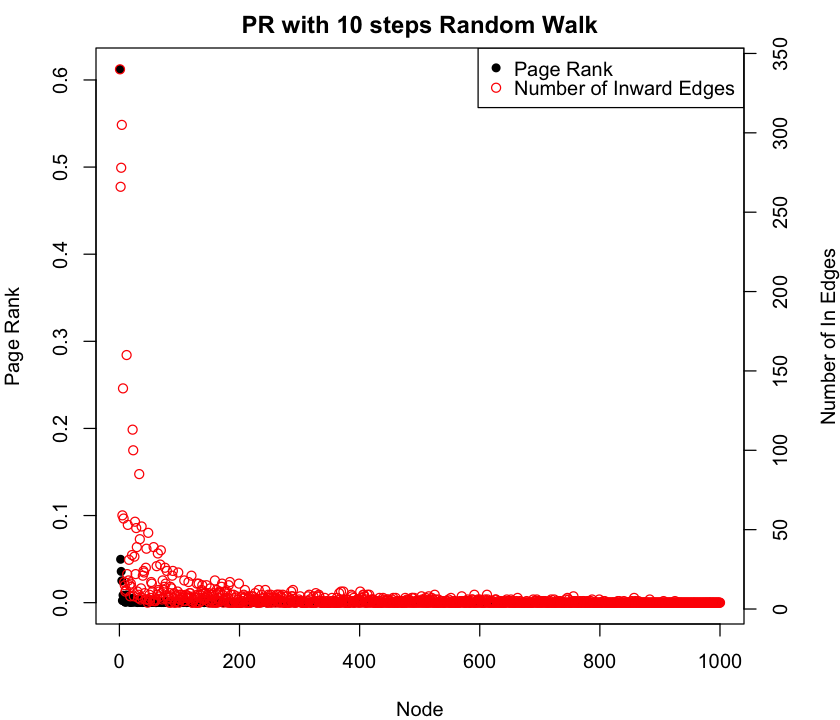

In [5]:
teleport_p <- 0.15
trails <- 10000

TP_state <- array(1/n, n)
nodeVisitingCount <- array(0, n)

Tn <- rgeom(trails, 0.15)
for (jump in Tn){
    actualStep <- min(maxSteps, jump + 1)
    PMF <- as.vector(TP_state %*% jumpMatrix [, , actualStep])
    lastNode <- sample(vcount(g), 1, prob = PMF)
    nodeVisitingCount[lastNode] = nodeVisitingCount[lastNode] + 1
}

PR_Density <- nodeVisitingCount / sum(nodeVisitingCount)

options(repr.plot.width=7, repr.plot.height= 6)
par(mar = c(4,4,2,4))
plot(V(g), PR_Density, 
     main=sprintf("PR with %d steps Random Walk", maxSteps), xlab="Node", ylab="Page Rank", pch = 16)
par(new = T)
plot(V(g), degree(g), col ="red", axes=F, xlab=NA, ylab=NA, pch = 1)
axis(side = 4)
mtext(side = 4, line = 3, 'Number of In Edges')
legend("topright", legend=c("Page Rank", "Number of Inward Edges"),
       pch=c(16, 1), col=c("black", "red"))
